# クラスタリングによるデータ分析
ポルトガルのリスボンにある卸売業者が顧客から集めたデータをクラスタリングによって、その傾向を分析する。

1. 教師なし学習について
2. データ取得
3. Feature Scaling
4. Feature Extraction
5. クラスタリング
6. k-means
7. クラスタリングの可視化
8. 卸売業者への報告
9. 今後の課題

## 1. 教師なし学習について

モデルを学習させるときに、正解が事前にわかっている教師あり学習に対して、教師なし学習は正解のないデータを扱うことであり、データの構造を調べて、分類し、意味のある情報を取り出すことができる。決して、**その分類が何かを答えるわけではなく、ただ分類するのみ **である。

** 主な用途 **  

１）クラスタリング
- データを分類し、関連性や類似性を見つけ出す。

２）次元削減
- 機械学習の前処理として学習速度や精度をあげる。
- 2, 3次元に削減することでデータを可視化。

** 具体例 **  
- 購買記録から顧客を分類し、販売戦略を考える
- アンケートなどの文章を分類し、どういった内容のものがあるか見る
- 不良品を分類し、工程の管理方法を考える

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2. データ取得
データセット：Wholesale customers Data Set  
https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

In [2]:
data = pd.read_csv("input/Wholesale customers data.csv")
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### 基本情報

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


- 総データ数：440
- 欠損値なし
- 変数：数値

### 不要な特徴量を除外
**Channel** と **Region** を除外し、年間の購入金額についての** 6つの特徴量のみでクラスタリング**

Channel：卸先顧客の業種
- Horeca（1）：「Hotel/Restaurant/Café」の略称
- Retail（2）：小売店

Region：卸先顧客の地域
- Lisbon（1）：首都リスボン
- Oporto（2）：第二の都市ポルト
- Other Region（3）：その他の地域

In [4]:
#元のデータはdata_originalに格納しておく
data_original = data.copy()

In [5]:
data=data.drop(["Channel","Region"],axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### ペアプロット

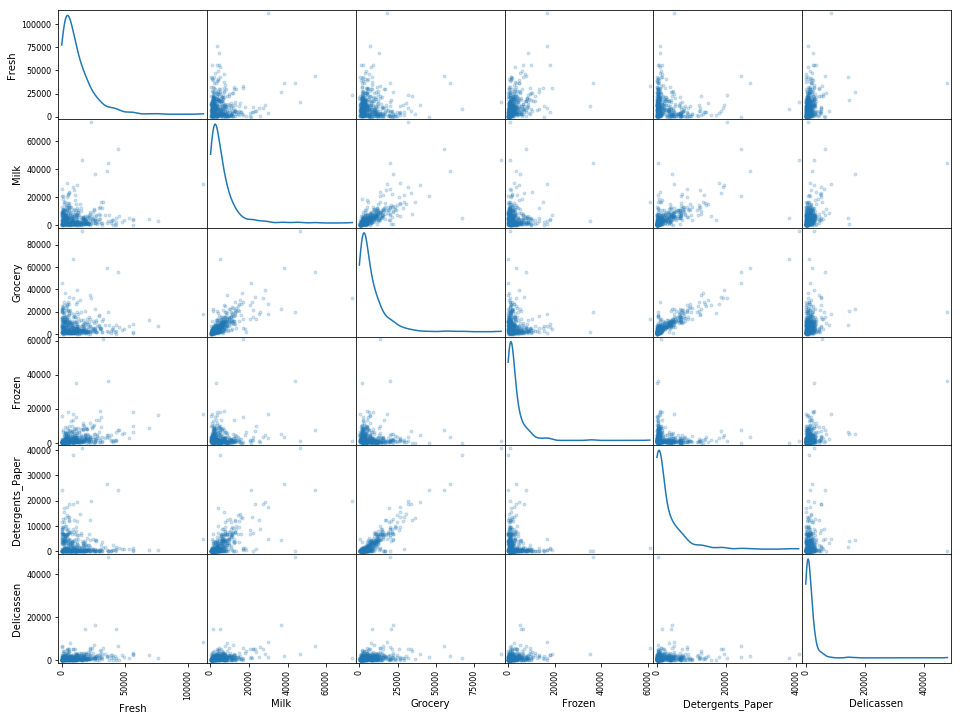

In [6]:
pd.scatter_matrix(data, alpha = 0.2, figsize = (16,12), diagonal = 'kde');

分布は偏っており、大半の顧客は相対的に少ない支出ですが、かなり多く支出している顧客も少数いることが分かる。  
また、多くの特徴量は無相関であるが、一部相関関係も見られる。

## 3. Feature Scaling

Feature Scaling に自然対数（log）を使用。

### Feature Scalingの必要性
特徴ごとのスケールが異なる場合、学習結果がスケールの大きい特徴の影響を強く受けてしまうため、  
Feature Scaling によってスケールを均一化する必要がある。

In [7]:
data_fs = np.log(data)
data_fs.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


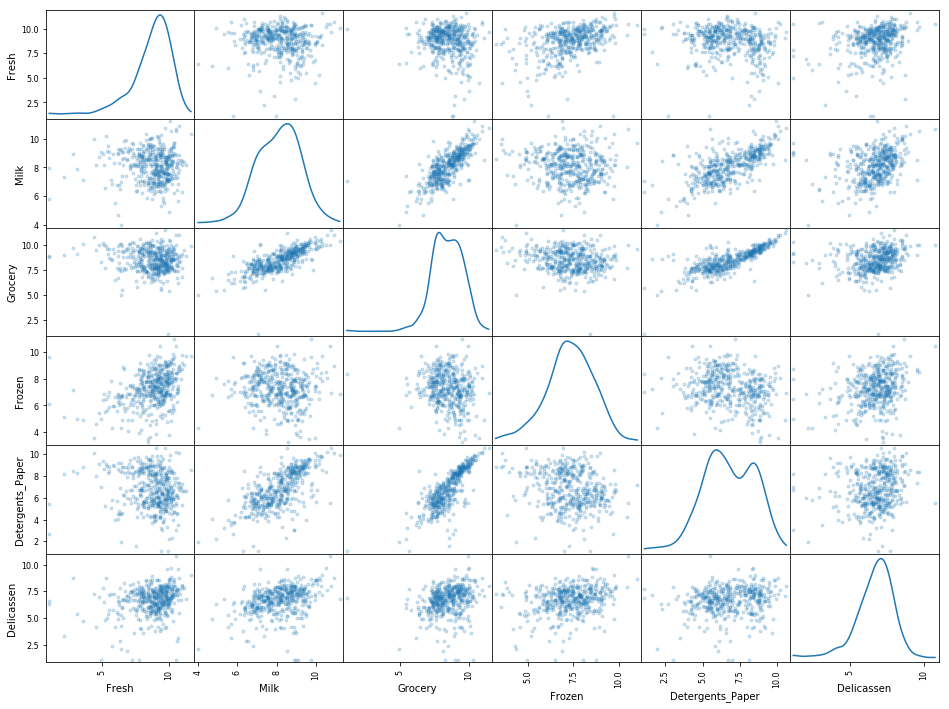

In [8]:
pd.scatter_matrix(data_fs, alpha = 0.2, figsize = (16,12), diagonal = 'kde');

## 4. Feature Extraction（特徴抽出）
### PCA
いくつまで次元数を削除するのが妥当か検証

In [9]:
from sklearn.decomposition import PCA
# n_components：成分数（指定しない場合は、データの次元数）
pca = PCA(n_components=None)
pca.fit(data_fs)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
# 各成分の分散説明率
var_exp = pca.explained_variance_ratio_
var_exp

array([0.44237417, 0.27657107, 0.11617342, 0.09617719, 0.0457568 ,
       0.02294735])

In [11]:
# 分散説明率の累積
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.44237417, 0.71894523, 0.83511865, 0.93129585, 0.97705265,
       1.        ])

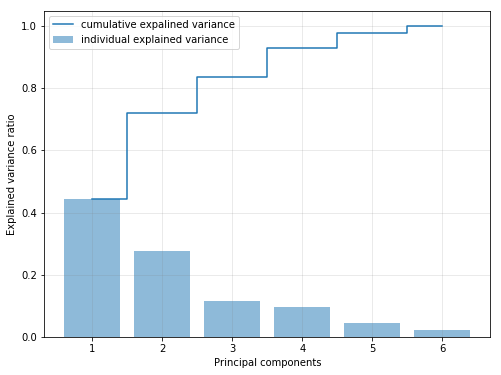

In [12]:
plt.figure(figsize =(8,6))
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.grid(color='gray', alpha=0.2)
plt.show()

第2主成分までで、累積分散説明率が70％を超えている。  

### 固有値
固有値（各主成分におけるデータの分散）からも分散説明率を算出できる。

In [13]:
# 各主成分の固有値
explained_variance = pca.explained_variance_
explained_variance

array([4.83781898, 3.02459061, 1.27047648, 1.05179707, 0.50039796,
       0.25095302])

In [14]:
# 各主成分の寄与率
explained_variance_ratio = explained_variance / explained_variance.sum()
explained_variance_ratio

array([0.44237417, 0.27657107, 0.11617342, 0.09617719, 0.0457568 ,
       0.02294735])

In [15]:
# 第1主成分、第2主成分、それぞれの寄与率の和
explained_variance_ratio[0] + explained_variance_ratio[1]

0.7189452317370728

同じく第2主成分までで、累積分散説明率が70％を超えている。  

### 固有ベクトル
固有ベクトル（各主成分）を求める。

In [16]:
pca.components_

array([[ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
        -0.1494356 ],
       [-0.68513571, -0.16239926, -0.06937908, -0.487691  , -0.04191162,
        -0.50970874],
       [-0.67351166,  0.03306794, -0.03218274,  0.28481122, -0.21824404,
         0.64459672],
       [-0.21432619,  0.0185577 ,  0.06448674,  0.80608348,  0.19005006,
        -0.51348977],
       [-0.00082162,  0.72228834,  0.34799325, -0.03624337, -0.56366476,
        -0.19536639],
       [-0.02927638,  0.54303508, -0.81390826, -0.0174477 ,  0.20244363,
        -0.02283197]])

In [17]:
# 分散説明率が 70% を超えている第2主成分までを選ぶ。
pca_vector= pca.components_[0:2]
print("第1主成分：",pca_vector[0])
print("第2主成分：",pca_vector[1])

第1主成分： [ 0.17371704 -0.394463   -0.45436364  0.17219603 -0.74551495 -0.1494356 ]
第2主成分： [-0.68513571 -0.16239926 -0.06937908 -0.487691   -0.04191162 -0.50970874]


### 機械学習の前処理としてのPCAの必要性
PCAを行うと特徴量の次元を削減することができる。  
これによって情報量を大きく損なうことなく学習データ量を減らすことができ、** 学習の速度を上げる **ことになる。  
また、高次元データのままで学習させると、汎用性に乏しい特異なパターンを学習してしまうリスクが高くなるが、  
PCAの次元削減によってそのリスクを減らすことができ、**モデルの精度向上 **につながる。

## 5. クラスタリング
クラスタリングとは、複数のデータを特徴が似たデータ同士のグループに分ける時に用いる教師なし学習の手法。  
大きく２つの手法に分けられる。  

** 階層的手法 **  
事前にグループ数を指定せず、関係や距離が近いものから順番に組み合わせていき、階層によって任意にクラスタリングする手法。

** 非階層的手法 **  
事前にグループ数を指定。すべての距離を計算する必要がないので大規模なデータも短時間でクラスタリングできる反面、開始点がランダムに決まるため結果が変わることがあり、再現性に弱い。

クラス分類との違いは、どういう特徴ごとにグループを分けるかが予め決まっていないという点である。

### まずはいくつか手法を用いて クラスタ数 の値を検討する。

### １）樹状図を描く  
まずは階層的手法を使い、樹状図を描画。今回は** ward法 **を使用。

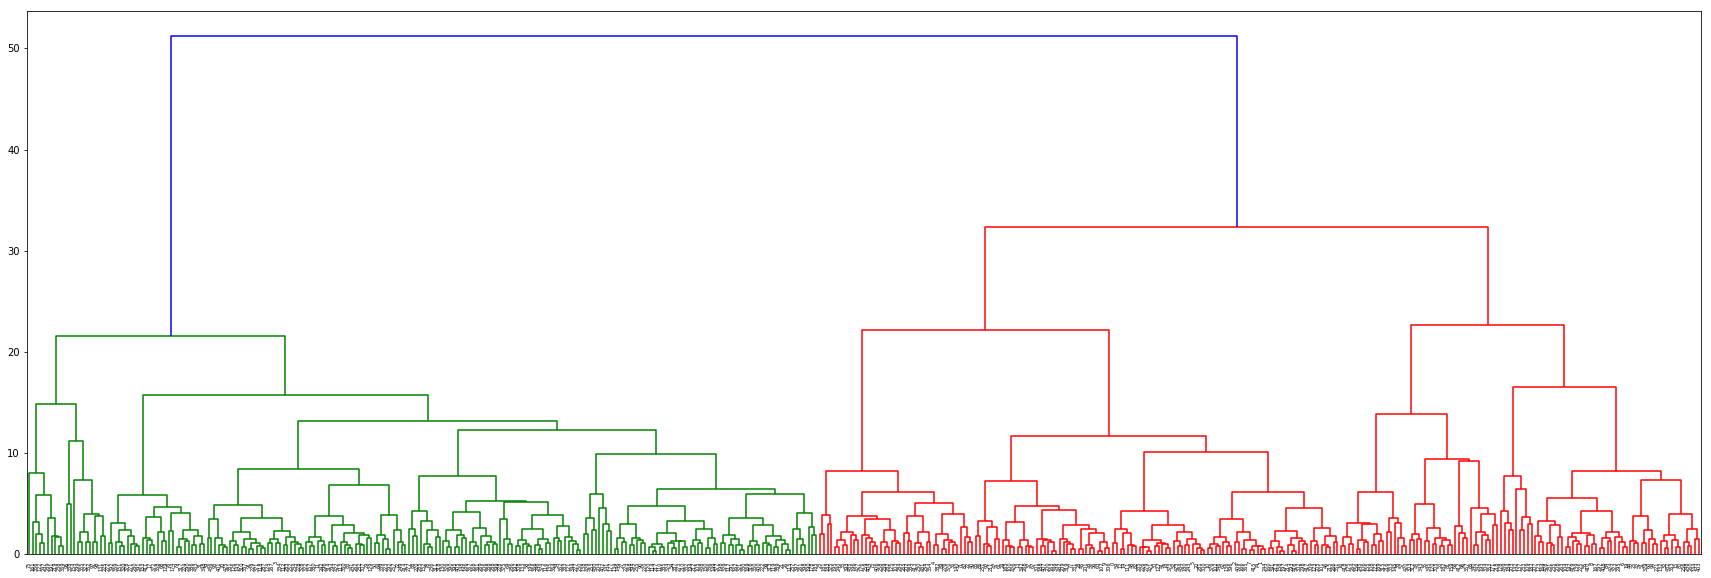

In [18]:
from scipy.cluster.hierarchy import dendrogram,ward,linkage

fig = plt.figure(figsize=(30,10)) 
affinity = 'ward'
Z = linkage(data_fs, affinity)
dn=dendrogram(Z)
plt.show()

大きく2つにクラスタリングできるのではないかと考えられる。

### ２）エルボー法  

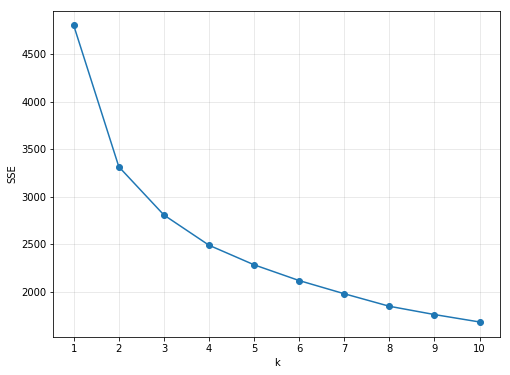

In [19]:
from sklearn.cluster import KMeans
SSE = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(data_fs)
    SSE.append(km.inertia_)

plt.figure(figsize =(8,6))
plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(range(1,11))
plt.grid(color='gray', alpha=0.2)
plt.show()

エルボー法の結果から、線の傾きの変化が k=2 の前後で最も大きい。

### ３）シルエット法

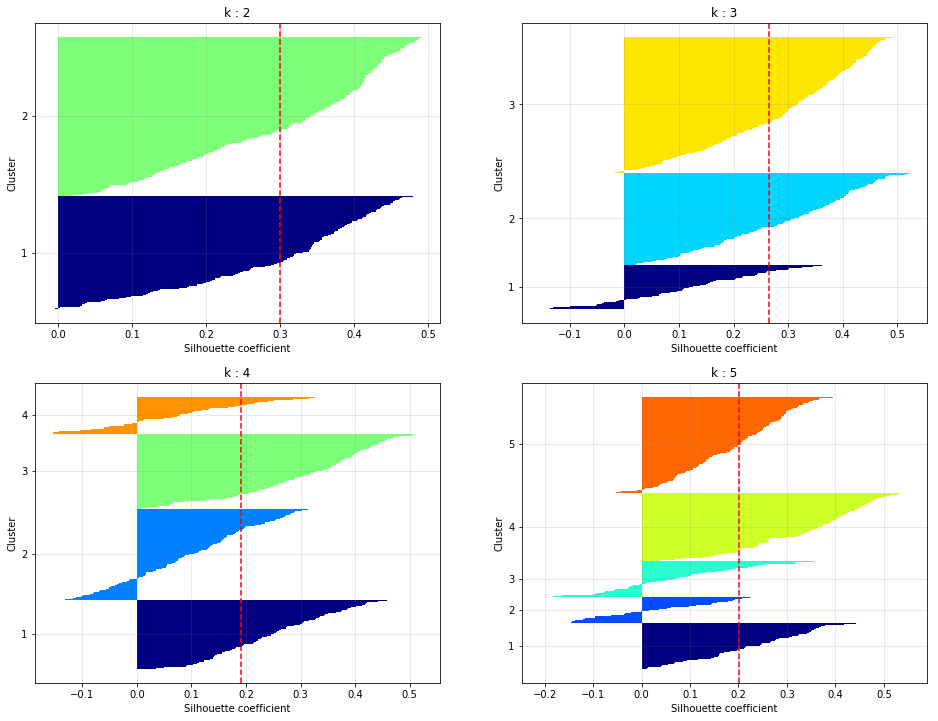

In [20]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(16, 32))
for i0 in range(1, 5):
    km = KMeans(n_clusters=i0+1, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(data_fs)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data_fs, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.subplot(5,2,i0)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title("k : "+ str(i+1))
    plt.grid(color='gray', alpha=0.2)
        
plt.show()

シルエット法の結果から、k=2 のとき、各 Cluster が平均シルエット係数を超えており、形状もよく似ている。  
以上のことから** k=2 **が妥当と考える。

## 6. k-means

k-means とは** 非階層クラスター分析 **の代表的手法  
Cluster の平均値を考えながら、指定したk個のクラスタに分類

1. k個の中心点をランダムに選ぶ。
2. 各サンプルを最も近い中心点に割り当て Cluster を作る。
3. クラスタの実際の中心（＝平均）を計算し、そこを新たな中心点とする（中心点の更新）
4. 2〜3を繰り返す。割り当てられるサンプルが変わらなくなったら終了。

** KMeans引数 **  
- **n_cluster**：Cluster の数（中心点の数）
- **init**：中心点の初期値の取り方のrandomかk-means++で指定（k-means++は初期値の取り方を改善した方法）
- **n_init**：k-menas自体を繰り返す回数
- **max_iter**：2〜3を繰り返す最大回数（繰り返しのことをイテレーション、iterationと呼ぶ）
- **tol**：4での終了判定に使われる許容値
- **random_state**：中心点の初期値のための乱数の状態を固定（これでKMeansクラスを実行するたびに違う結果になることはない）

## 7. クラスタリングの可視化
PCAにより可視化可能な次元にまで削減されたデータを用いてプロット

### PCAによる次元削減

In [21]:
# 第1・第2主成分（固有ベクトル）
pca_vector

array([[ 0.17371704, -0.394463  , -0.45436364,  0.17219603, -0.74551495,
        -0.1494356 ],
       [-0.68513571, -0.16239926, -0.06937908, -0.487691  , -0.04191162,
        -0.50970874]])

In [22]:
pca_vector.shape

(2, 6)

In [23]:
# Feature Scaling したデータ
data_fs.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


In [24]:
data_fs.shape

(440, 6)

In [25]:
# PCAによる次元削減（2次元）
data_pca = np.dot( data_fs, pca_vector.T)
data_pca[:10,:]

array([[-12.07093426, -15.19912779],
       [-12.12031428, -15.99836614],
       [-12.21368491, -16.80523328],
       [ -9.19263597, -16.58659485],
       [-11.1166604 , -17.58947825],
       [-11.40377264, -15.521555  ],
       [-11.45255896, -14.9270107 ],
       [-11.90242271, -16.09680899],
       [-11.19177415, -14.53185367],
       [-13.20883208, -15.86971509]])

### 次元削減データのクラスタリング

In [26]:
# PCAによる次元削減データに、k=2 の k-means を実行してクラスタリング
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
km.fit(data_pca)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [27]:
km_pca = km.predict(data_pca)
km_pca

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,

0, 1 にクラスタリングできたことがわかる。

### クラスタリングしたグループを主成分軸でプロット

In [28]:
# 各 Cluster データ
cluster_0=data_pca[km_pca==0]
cluster_1=data_pca[km_pca==1]

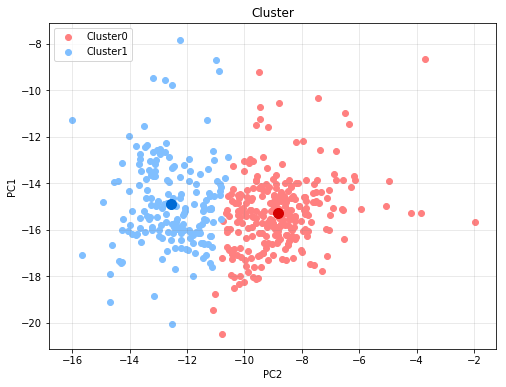

In [29]:
plt.figure(figsize =(8,6))
# cluster_0 のデータをプロット
plt.scatter(cluster_0[:,0], cluster_0[:,1], c="#ff8080", label='Cluster0')
# cluster_1 のデータをプロット
plt.scatter(cluster_1[:,0], cluster_1[:,1], c="#80bfff", label='Cluster1')
# cluster_0 のデータの中心座標
plt.scatter(km.cluster_centers_[0][0],km.cluster_centers_[0][1],s=100, c='#d50000')
# cluster_1 のデータの中心座標
plt.scatter(km.cluster_centers_[1][0],km.cluster_centers_[1][1],s=100, c='#006ad5')
plt.title('Cluster')
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.grid(color='gray', alpha=0.2)
plt.legend(loc='best')
plt.show()

### 業種・地域 それぞれのグループを主成分軸でプロット

In [30]:
data_original.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [31]:
# 各Channelデータ
channel_1=data_pca[data_original["Channel"]==1]
channel_2=data_pca[data_original["Channel"]==2]

In [32]:
# 各regionデータ
region_1=data_pca[data_original["Region"]==1]
region_2=data_pca[data_original["Region"]==2]
region_3=data_pca[data_original["Region"]==3]

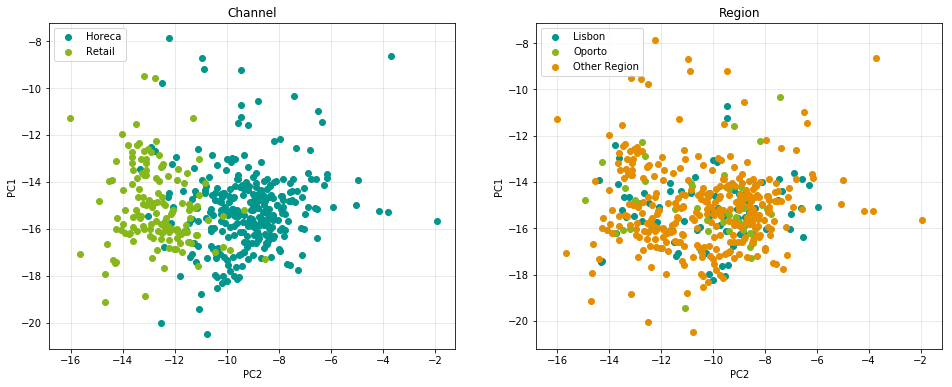

In [33]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.scatter(channel_1[:,0], channel_1[:,1], c="#00958D", label='Horeca')
plt.scatter(channel_2[:,0], channel_2[:,1], c="#86B81B", label='Retail')
plt.title('Channel')
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.grid(color='gray', alpha=0.2)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.scatter(region_1[:,0], region_1[:,1], c="#00958D", label='Lisbon')
plt.scatter(region_2[:,0], region_2[:,1], c="#86B81B", label='Oporto')
plt.scatter(region_3[:,0], region_3[:,1], c="#E48E00", label='Other Region')
plt.title('Region')
plt.ylabel('PC1')
plt.xlabel('PC2')
plt.grid(color='gray', alpha=0.2)
plt.legend(loc='best')

plt.show()

**Channel**  
上記 Cluster の散布図と類似していることがわかる。  
今回のクラスタリングは** Channel の影響を大きく受けている **と考えられ、**Cluster0 が Horeca、Cluster1 が Retail と推察できる。**  
また Horeca は「Hotel / Restaurant / Café」の略称ということだが、そもそも、これらの業種を一括りくくるのには無理があるように思う。  
となると、**Horeca の多くが属しているであろう Cluster1 も、無理なくクラスタリングできるのではないか**と考えられる。

**Region**  
Cluster への影響はほとんどないと考えられる。

Channel に的を絞り、さらにクラスタリングを検証していく。

### 新たな特徴量を追加
顧客ごとに各商品購入金額の合計を追加

In [34]:
data_original['TotalPrice'] = data_original['Fresh'] + data_original['Milk'] + data_original['Grocery']+\
                              data_original['Frozen']+data_original['Detergents_Paper']+data_original['Delicassen']

In [35]:
data_original["km_pca"] = km_pca

In [36]:
data_original.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,TotalPrice,km_pca
0,2,3,12669,9656,7561,214,2674,1338,34112,1
1,2,3,7057,9810,9568,1762,3293,1776,33266,1
2,2,3,6353,8808,7684,2405,3516,7844,36610,1
3,1,3,13265,1196,4221,6404,507,1788,27381,0
4,2,3,22615,5410,7198,3915,1777,5185,46100,1


### 商品購入金額、及び購入合計金額、それぞれの平均を算出

In [37]:
cluster_0_df=data_original[data_original["km_pca"]==0].drop(["Channel","Region","km_pca"], axis=1).mean()
cluster_0_df

Fresh               14318.973384
Milk                 2961.908745
Grocery              3287.653992
Frozen               4073.661597
Detergents_Paper      476.460076
Delicassen           1353.756654
TotalPrice          26472.414449
dtype: float64

In [38]:
cluster_1_df=data_original[data_original["km_pca"]==1].drop(["Channel","Region","km_pca"], axis=1).mean()
cluster_1_df

Fresh                8555.033898
Milk                10007.768362
Grocery             14880.841808
Frozen               1583.485876
Detergents_Paper     6455.073446
Delicassen           1779.124294
TotalPrice          43261.327684
dtype: float64

In [39]:
horeca_df=data_original[data_original["Channel"]==1].drop(["Channel","Region","km_pca"], axis=1).mean()
horeca_df

Fresh               13475.560403
Milk                 3451.724832
Grocery              3962.137584
Frozen               3748.251678
Detergents_Paper      790.560403
Delicassen           1415.956376
TotalPrice          26844.191275
dtype: float64

In [40]:
retail_df=data_original[data_original["Channel"]==2].drop(["Channel","Region","km_pca"], axis=1).mean()
retail_df

Fresh                8904.323944
Milk                10716.500000
Grocery             16322.852113
Frozen               1652.612676
Detergents_Paper     7269.507042
Delicassen           1753.436620
TotalPrice          46619.232394
dtype: float64

### Cluster と Channel の比較

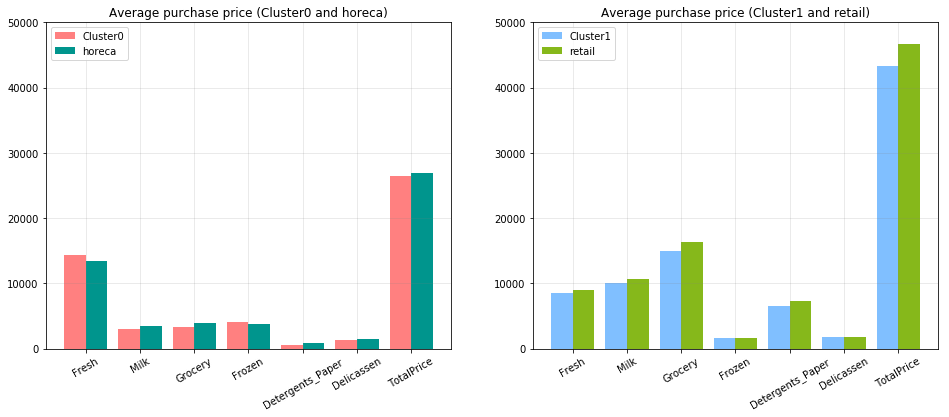

In [41]:
x  = np.array(range(7))
bar_width = 0.4

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.bar(x, cluster_0_df, width = bar_width, label = "Cluster0" ,color="#ff8080")
plt.bar(x + bar_width, horeca_df, width = bar_width, label = "horeca", color="#00958D")
plt.legend(loc='upper left')
plt.xticks(x + bar_width / 2, cluster_0_df.index, rotation=30)
plt.ylim(0,50000)
plt.title("Average purchase price (Cluster0 and horeca)")
plt.grid(color='gray', alpha=0.2)

plt.subplot(1, 2, 2)
plt.bar(x, cluster_1_df, width = bar_width, label = "Cluster1" ,color="#80bfff")
plt.bar(x + bar_width, retail_df, width = bar_width, label = "retail", color="#86B81B")
plt.legend(loc='upper left')
plt.xticks(x + bar_width / 2, cluster_1_df.index, rotation=30)
plt.ylim(0,50000)
plt.title("Average purchase price (Cluster1 and retail)")
plt.grid(color='gray', alpha=0.2)

plt.show()

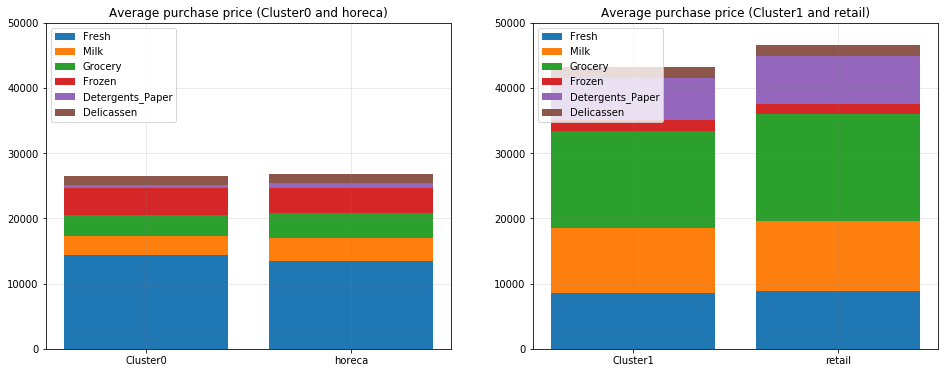

In [52]:
#color=["#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50","#8BC34A"]

plt.figure(figsize=(16, 6))


plt.subplot(1, 2, 1)
x = np.array(["Cluster0", "horeca"])
label=cluster_0_df.index.drop("TotalPrice")
for i in range(6):
    bottom=0
    if i == 0:
        plt.bar(x, np.array([cluster_0_df[i], horeca_df[i]]), label = label[i] )
    else:
        for j in range(i):
            bottom += np.array([cluster_0_df[j], horeca_df[j]])
        plt.bar(x, np.array([cluster_0_df[i], horeca_df[i]]), label = label[i], bottom=bottom )
plt.legend(loc='upper left')
plt.ylim(0,50000)
plt.title("Average purchase price (Cluster0 and horeca)")
plt.grid(color='gray', alpha=0.2)


plt.subplot(1, 2, 2)
x = np.array(["Cluster1", "retail"])
label=cluster_1_df.index.drop("TotalPrice")
for i in range(6):
    bottom=0
    if i == 0:
        plt.bar(x, np.array([cluster_1_df[i], retail_df[i]]), label = label[i] )
    else:
        for j in range(i):
            bottom += np.array([cluster_1_df[j], retail_df[j]])
        plt.bar(x, np.array([cluster_1_df[i], retail_df[i]]), label = label[i], bottom=bottom )
plt.legend(loc='upper left')
plt.ylim(0,50000)
plt.title("Average purchase price (Cluster1 and retail)")
plt.grid(color='gray', alpha=0.2)


plt.show()

商品購入金額、及び購入合計金額、それぞれの平均金額で Cluster と Channel を比較すると、**Cluster0 / horeca、Cluster1 / retail **に同じような傾向があることが、あらためて分かる。


## 8. 卸売業者への報告

In [43]:
c_0=data_original[data_original["km_pca"]==0].drop(["km_pca"], axis=1)
c_1=data_original[data_original["km_pca"]==1].drop(["km_pca"], axis=1)

### Cluster0 要約統計量

In [44]:
c_0.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,TotalPrice
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,1.026616,2.513308,14318.973384,2961.908745,3287.653992,4073.661597,476.460076,1353.756654,26472.414449
std,0.161265,0.795271,12913.221783,3861.622017,2866.787926,5870.004863,516.194506,3193.414831,20820.042872
min,1.000000,1.000000,3.000000,55.000000,3.000000,47.000000,3.000000,3.000000,904.000000
25%,1.000000,2.000000,5077.000000,1063.000000,1644.500000,909.500000,168.500000,387.000000,13485.000000
50%,1.000000,3.000000,10766.000000,1917.000000,2469.000000,2279.000000,325.000000,790.000000,21259.000000
75%,1.000000,3.000000,19153.000000,3648.500000,4099.500000,5293.000000,629.500000,1449.500000,32955.500000
max,2.000000,3.000000,76237.000000,43950.000000,20170.000000,60869.000000,4762.000000,47943.000000,185683.000000


### Cluster1 要約統計量

In [45]:
c_1.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,TotalPrice
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1.762712,2.587571,8555.033898,10007.768362,14880.841808,1583.485876,6455.073446,1779.124294,43261.327684
std,0.426627,0.741975,11435.703573,9155.568979,11499.374757,1940.178805,5900.747765,2132.505144,30297.970843
min,1.000000,1.000000,3.000000,1115.000000,2824.000000,25.000000,223.000000,3.000000,10547.000000
25%,2.000000,2.000000,1989.000000,5291.000000,8040.000000,417.000000,3084.000000,531.000000,27289.000000
50%,2.000000,3.000000,5283.000000,7555.000000,11522.000000,1026.000000,4618.000000,1328.000000,35079.000000
75%,2.000000,3.000000,11594.000000,11103.000000,18683.000000,1920.000000,7425.000000,2157.000000,49039.000000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,16745.000000,40827.000000,16523.000000,199891.000000


### 各 Cluster ごとの Channel の内訳

In [46]:
print("Cluster0")
print("Horeca:",c_0["Channel"].value_counts()[1])
print("Retail:",c_0["Channel"].value_counts()[2])

Cluster0
Horeca: 256
Retail: 7


In [47]:
print("Cluster1")
print("Horeca:",c_1["Channel"].value_counts()[1])
print("Retail:",c_1["Channel"].value_counts()[2])

Cluster1
Horeca: 42
Retail: 135


### 各 Cluster に対する戦略とそれぞれの属性

### Cluster0 について
戦略  
- **生鮮食品・冷凍食品 **の情報を掲載したチラシやDMを送るといったマーケティング戦略
- 異業種でカテゴライズされている Horeca（Hotel / Restaurant / Café）ですが、その多くが属しているであろう Cluster0 に対して、  
さらなるクラスタリングできる余地があると考えられる。

属性
- データ数：263（Horeca：256、Retail：7）  
- **年間購買額が低い傾向（平均26472ユーロ） ** 
- 生鮮食品・冷凍食品の平均購買額が比較的高い
  



### Cluster1 について
戦略
- **洗剤および紙製品を主軸に、乳製品・食料品 **の情報を掲載したチラシやDMを送るといったマーケティング戦略
- **年間購買額が高い傾向がある Cluster1 の戦略を優先**

属性
- データ数：177（Horeca：42、Retail：135）  
- **年間購買額が高い傾向（平均43261ユーロ）**  
- 乳製品・食料品の平均購買額が比較的高いが、 なかでも洗剤および紙製品が圧倒的に高い


上記、各 Cluster の属性とCSVファイルでもって、卸売業者への報告成果品とする。

In [48]:
c_0.to_csv('c_0.csv')
c_1.to_csv('c_1.csv')

## 9. 今後の課題
- クラスタリングのさらなる深掘り（AIF_sprint-6-教師なし学習参照）